In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-08T00:39:44.788178+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [4]:
from xgboost import __version__ as xgb_version
from sklearn import __version__ as sklearn_version

print(f'xgb_version: {xgb_version}')
print(f'sklearn_version: {sklearn_version}')

xgb_version: 1.6.1
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

pandas : 0.25.3
numpy  : 1.20.3
sklearn: 0.24.2



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [8]:
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [9]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5589, 978), (1398, 978), (3000, 974), 0, 942)

отделяем метки от данных

In [10]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5589, 975), (1398, 975), (5589, 3), (1398, 3))

In [11]:
#cat_cols + num_cols

In [12]:
#num_cols = ['ctr']#, 'weekend']

In [13]:
def plot_importance(inp_model, imp_number = 30, imp_type = 'weight'):
    feature_important = inp_model.get_booster().get_score(importance_type=imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(imp_number, columns="score").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

## views

In [14]:
xgb_model_views = XGBRegressor(n_estimators=1000, 
                               max_depth=7, 
                               eta=0.1, 
                               #subsample=0.7, 
                               colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_views.fit(x_train[num_cols], y_train['views'], 
                    early_stopping_rounds=5,
                    eval_set=[(x_val[num_cols], y_val['views'])], 
                    verbose=False
                   )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, ...)

In [15]:
# Get predictions and metrics
preds_train_views = xgb_model_views.predict(x_train[num_cols])
preds_val_views   = xgb_model_views.predict(x_val[num_cols])

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.7838796323023496, 0.2525518171936103)

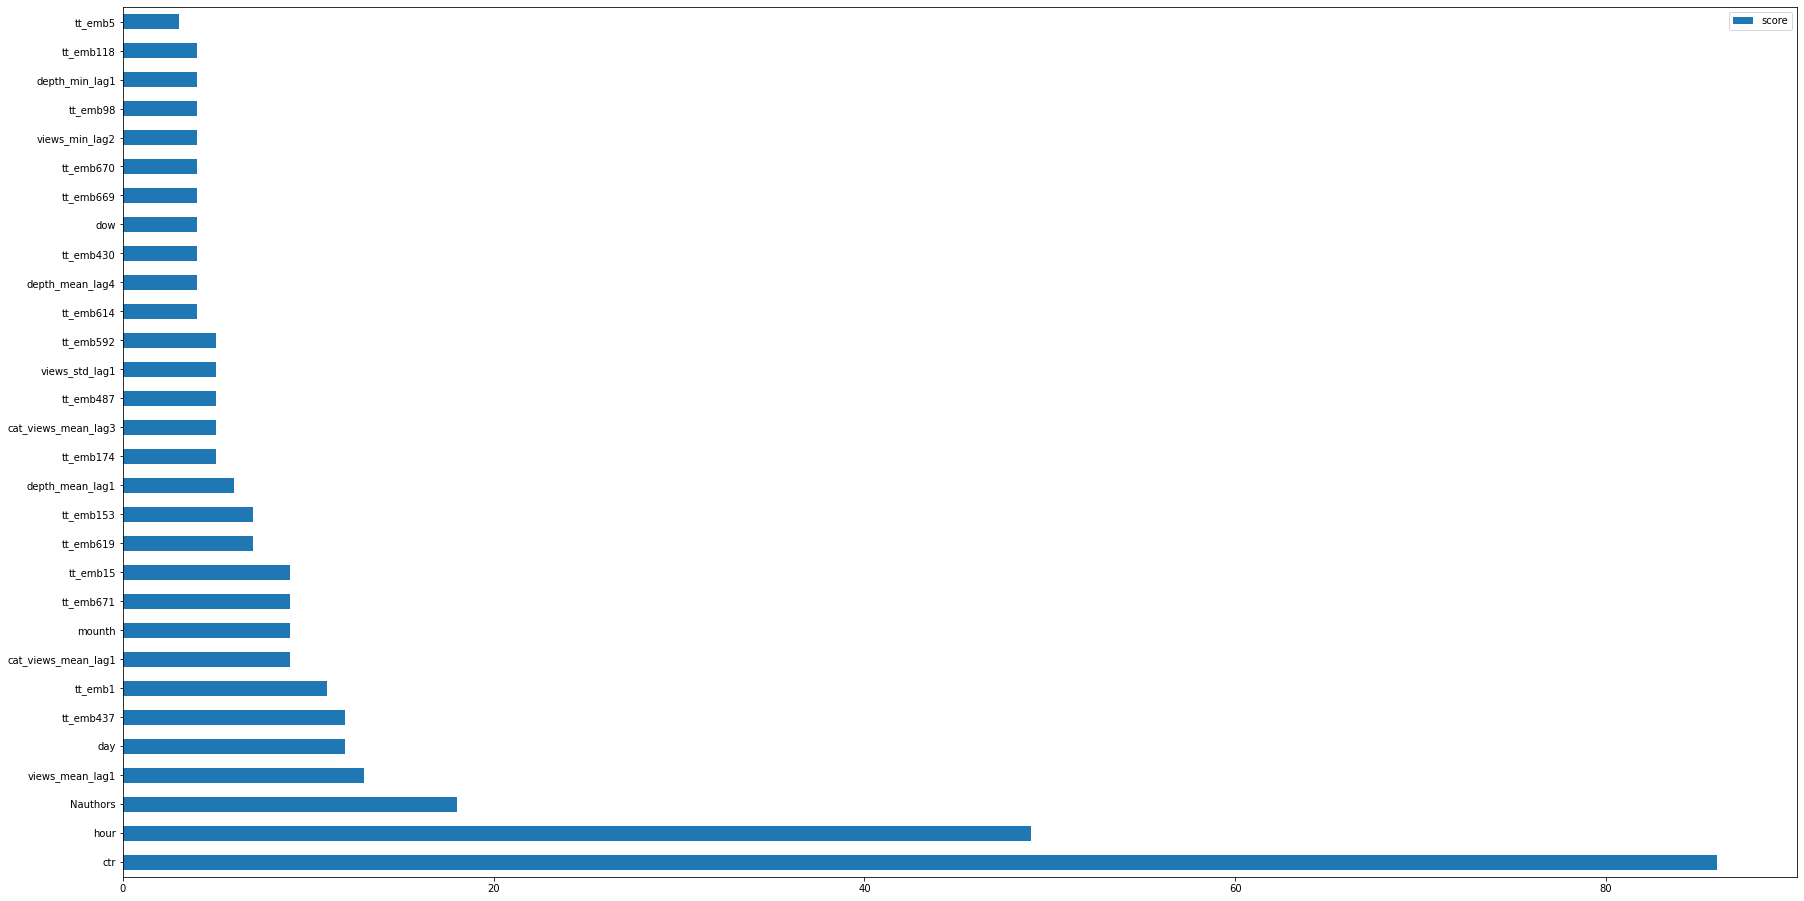

In [16]:
plot_importance(xgb_model_views, 30, 'weight')

## depth

In [17]:
xgb_model_depth = XGBRegressor(n_estimators=1000, 
                               max_depth=7, 
                               eta=0.1, 
                               #subsample=0.7, 
                               colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_depth.fit(x_train[num_cols], y_train['depth'], 
                    early_stopping_rounds=5,
                    eval_set=[(x_val[num_cols], y_val['depth'])], 
                    verbose=False
                   )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, ...)

In [18]:
# Get predictions and metrics
preds_train_depth = xgb_model_depth.predict(x_train[num_cols])
preds_val_depth   = xgb_model_depth.predict(x_val[num_cols])

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.9460145907792209, 0.7656732494193562)

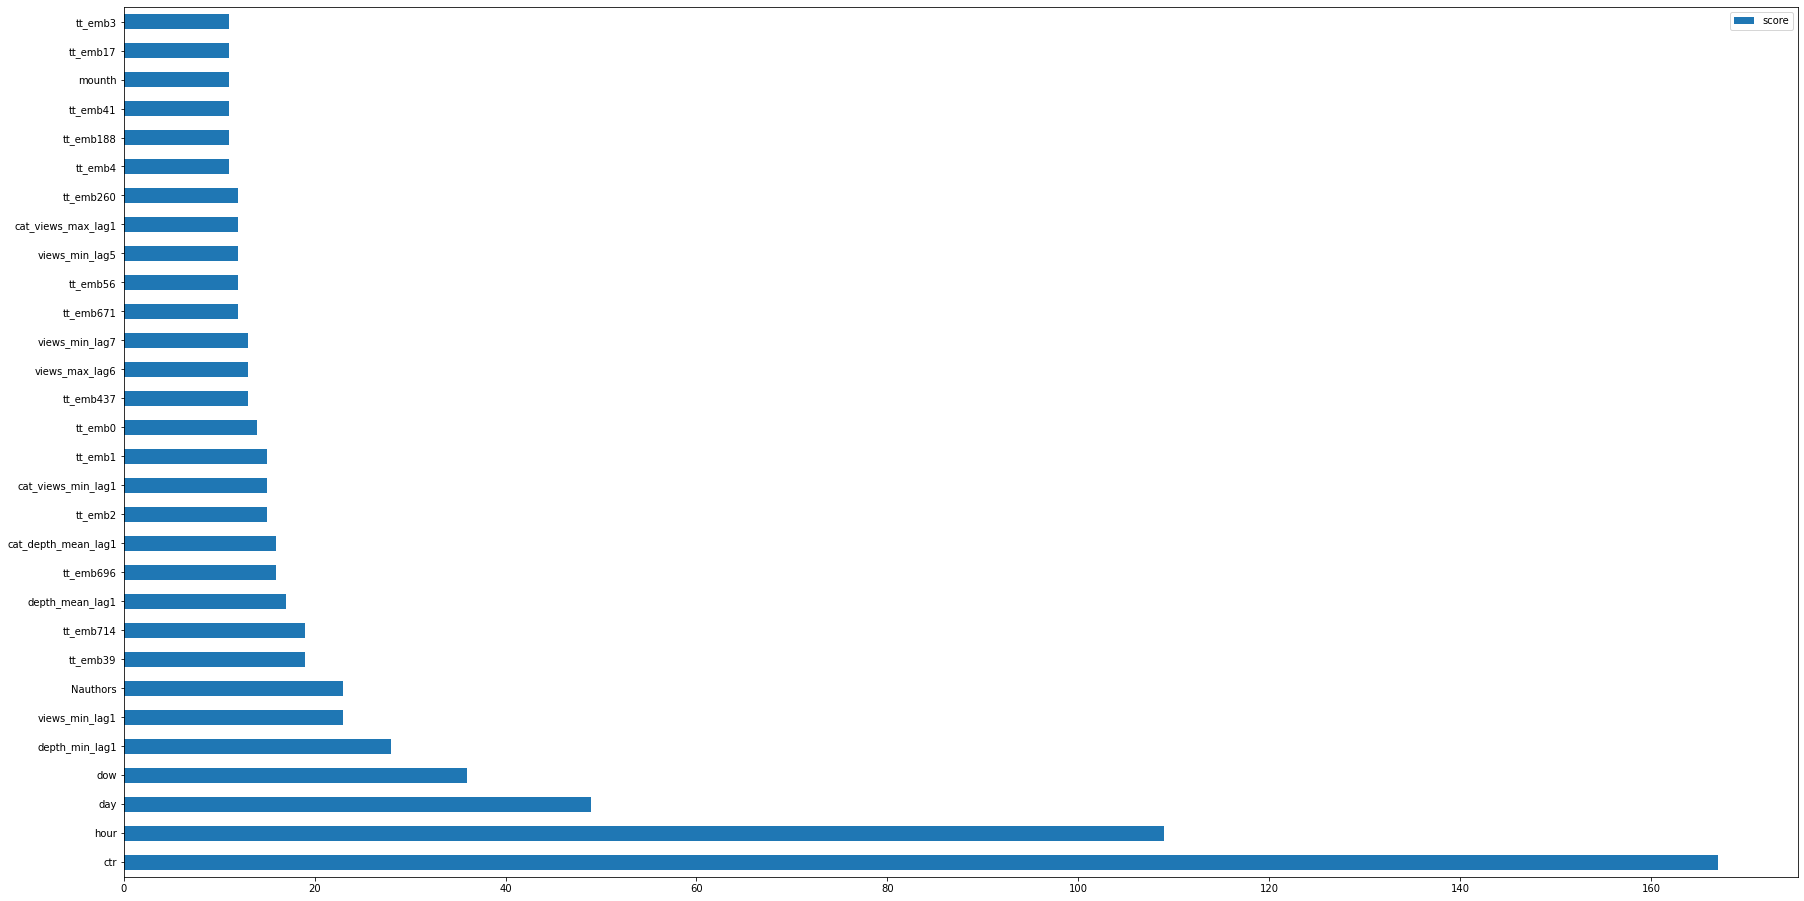

In [19]:
plot_importance(xgb_model_depth, 30, 'weight')

## full_reads_percent

In [20]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])


In [22]:
print('before ', x_train.shape, x_val.shape, preds_train_depth.shape, preds_val_depth.shape)
x_train = pd.concat([x_train, pred_depth_train], axis = 1)
x_val   = pd.concat([x_val,   pred_depth_val],   axis = 1)
print('after  ', x_train.shape, x_val.shape)

before  (5589, 975) (1398, 975) (5589,) (1398,)
after   (6704, 976) (2541, 976)


In [21]:
xgb_model_frp = XGBRegressor(n_estimators=1000, 
                             max_depth=7, 
                             eta=0.1, 
                             #subsample=0.7, 
                             colsample_bytree=0.8,
                             n_jobs = -1,
                             random_state = XGB_RANDOMSEED,
                             )

xgb_model_frp.fit(x_train[num_cols], 
                  y_train['full_reads_percent'], 
                  early_stopping_rounds=5,
                  eval_set=[(x_val[num_cols], 
                             y_val['full_reads_percent'])
                           ], 
                  verbose=False
                 )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, ...)

In [ ]:
# Get predictions and metrics
preds_train_frp = xgb_model_frp.predict(x_train[num_cols])
preds_val_frp   = xgb_model_frp.predict(x_val[num_cols])

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

In [ ]:
plot_importance(xgb_model_frp, 30, 'weight')

In [ ]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val   = 0.4 * val_score_views   + 0.3 * val_score_depth   + 0.3 * val_score_frp

score_train, score_val

In [ ]:
NTRY = 6

## save models

In [ ]:
xgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_1_xgb_views.json'), 
                          )

xgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NTRY}_1_xgb_depth.json'), 
                          )

xgb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NTRY}_1_xgb_frp.json'), 
                        )

## make predict

In [ ]:
pred_views = xgb_model_views.predict(df_test[num_cols])
pred_depth = xgb_model_depth.predict(df_test[num_cols])
pred_frp   = xgb_model_frp.predict(  df_test[num_cols])

In [ ]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [ ]:
subm.head()

In [ ]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_1_xgb_lags_emb_dp.csv'), index = False)